<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/RF_KFOLD_v5_for_CML_rf_final_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

### train test validate splite

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,train_labe_encoded,test_size=0.20,shuffle=True,random_state=42,stratify=train_labe_encoded)

In [11]:
print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(5653, 32, 32, 3) ---- (5653,)
(1414, 32, 32, 3) ---- (1414,)


In [12]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

In [13]:
shape = (32,32,3)

### GoogleNet

In [14]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [15]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [16]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [17]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [18]:
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [19]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])
"""
out = Dense(64,activation='relu')(out)
out = Dropout(0.40)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)"""

"\nout = Dense(64,activation='relu')(out)\nout = Dropout(0.40)(out)\nout = Dense(128,activation='relu')(out)\nout = Dropout(0.45)(out)\nout = Dense(256,activation='relu')(out)\n#out = Dropout(0.50)(out)\n\n\noutput = Dense(8,activation='softmax')(out)"

In [20]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = out)

In [21]:
print("Feature extraction ...Training")
prediction_tr = np.array(e_model.predict([x_tr,x_tr]))
prediction_tr.shape

Feature extraction ...Training


(5653, 480)

In [22]:
Xtrain = np.reshape(prediction_tr, (prediction_tr.shape[0], prediction_tr.shape[1]))

In [ ]:
print("Feature extraction ...validation")
prediction_v = np.array(e_model.predict([x_v,x_v]))
prediction_v.shape

Feature extraction ...validation


(1413, 8)

In [ ]:
Xvalidate = np.reshape(prediction_v, (prediction_v.shape[0], prediction_v.shape[1]))

In [23]:
print("Feature extraction ...Testing")
prediction_tes = np.array(e_model.predict([x_te,x_te]))

Feature extraction ...Testing


In [24]:
Xtest = np.reshape(prediction_tes, (prediction_tes.shape[0], prediction_tes.shape[1]))

In [25]:
print('\tFeatures training shape: ', Xtrain.shape)
#print('\tFeatures testing shape: ', Xvalidate.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (5653, 480)
	Features testing shape:  (1414, 480)


### random forest

### ROC for SVM

In [26]:
labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

In [27]:
rfc=RandomForestClassifier(random_state=42)

In [28]:
param_grid = { 
    'n_estimators': [10,30,40,50,100,200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [29]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(Xtrain, y_tr)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 30, 40, 50, 100, 200, 500]})

In [30]:
print(CV_rfc.best_params_,CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500} 0.8572441200598458


In [31]:
df = pd.DataFrame(CV_rfc.cv_results_)
mask = df['rank_test_score']<10
newdf = df[mask]
newdf[['param_criterion','param_max_depth','param_max_features','param_n_estimators','mean_test_score','rank_test_score']]

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,rank_test_score
88,gini,8,auto,100,0.855828,7
89,gini,8,auto,200,0.855651,9
90,gini,8,auto,500,0.856890,3
95,gini,8,sqrt,100,0.855828,7
96,gini,8,sqrt,200,0.855651,9
97,gini,8,sqrt,500,0.856890,3
194,entropy,8,auto,200,0.856183,5
195,entropy,8,auto,500,0.857244,1
201,entropy,8,sqrt,200,0.856183,5
202,entropy,8,sqrt,500,0.857244,1


In [32]:
rfc=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 100, max_depth=8, criterion='entropy')

In [33]:
print('training values for Random Forest')
rfc.fit(Xtrain, y_tr)

training values for Random Forest


RandomForestClassifier(criterion='entropy', max_depth=8, max_features='log2',
                       random_state=42)

In [ ]:
predict_train = rfc.predict(Xtrain)

	Training Accuracy of RF: 0.8663


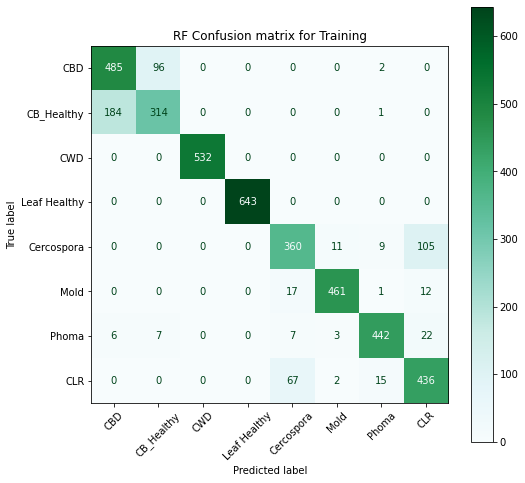

In [ ]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_train, np.ravel(y_tr, order='C'))
    print("\tTraining Accuracy of RF: %0.4f" % acc)
    cm = confusion_matrix(y_tr, predict_train, labels=rfc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("RF Confusion matrix for Training")
    plt.show()

predicting values for Random Forest validation
	Validation Accuracy of RF: 0.8273


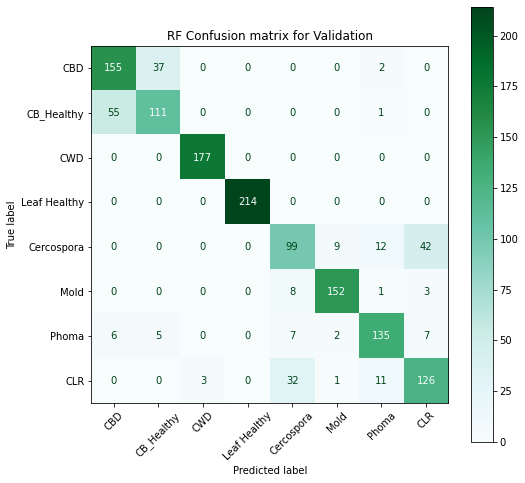

In [ ]:
    print('predicting values for Random Forest validation')
    predict_validate = rfc.predict(Xvalidate)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_validate, np.ravel(y_v, order='C'))
    print("\tValidation Accuracy of RF: %0.4f" % acc)
    cm = confusion_matrix(y_v, predict_validate, labels=rfc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("RF Confusion matrix for Validation")
    plt.show()

predicting values for Random Forest Testing
	Testing Accuracy of RF: 0.7977


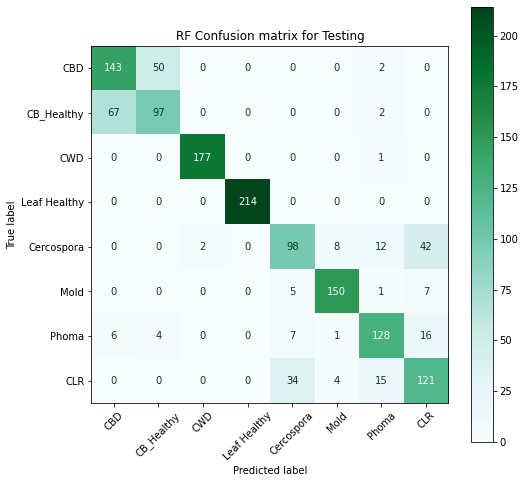

In [ ]:
    print('predicting values for Random Forest Testing')
    predict_test = rfc.predict(Xtest)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_test, np.ravel(y_tes, order='C'))
    print("\tTesting Accuracy of RF: %0.4f" % acc)
    cm = confusion_matrix(y_tes, predict_test, labels=rfc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("RF Confusion matrix for Testing")
    plt.show()

In [ ]:
print(classification_report(y_tes,predict_test,target_names=target_names))

              precision    recall  f1-score   support

         CBD       0.66      0.73      0.70       195
  CB_Healthy       0.64      0.58      0.61       166
         CWD       0.99      0.99      0.99       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.68      0.60      0.64       162
        Mold       0.92      0.92      0.92       163
       Phoma       0.80      0.79      0.79       162
         CLR       0.65      0.70      0.67       174

    accuracy                           0.80      1414
   macro avg       0.79      0.79      0.79      1414
weighted avg       0.80      0.80      0.80      1414



In [ ]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'CWD',3: 'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

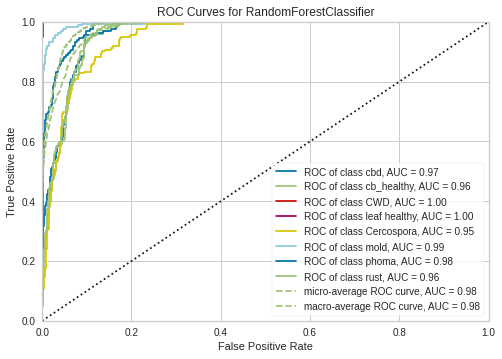

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f4cd630d610>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'CWD', 3: 'leaf healthy',
                4: 'Cercospora', 5: 'mold', 6: 'phoma', 7: 'rust'},
       estimator=RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='log2', random_state=42))

In [ ]:
plot_ROC_curve(rfc,Xtrain,y_tr,Xtest,y_tes)

### using k fold 

In [35]:
#skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
skfolds = KFold(n_splits=3)

In [36]:
rfc=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 500, max_depth=8, criterion='entropy')
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_trin,y_test=y_tr[trainset],y_tr[testset]

    #clone_clf = clone(svm)
    rfc.fit(x_tr, y_trin)
    predicted_labels = rfc.predict(x_te)
    accuracy = accuracy_score(y_test, predicted_labels)
    
    predicted_t_labels = rfc.predict(x_tr)
    accuracy_t = accuracy_score(y_trin, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_trin)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[1885 1886 1887 ... 5650 5651 5652] having : 3768
[   0    1    2 ... 1882 1883 1884] having : 1885
iteration 0
folds  1
[   0    1    2 ... 5650 5651 5652] having : 3769
[1885 1886 1887 ... 3766 3767 3768] having : 1884
iteration 1
folds  2
[   0    1    2 ... 3766 3767 3768] having : 3769
[3769 3770 3771 ... 5650 5651 5652] having : 1884
iteration 2


In [37]:
labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

	Validation Accuracy of RF: 0.8477


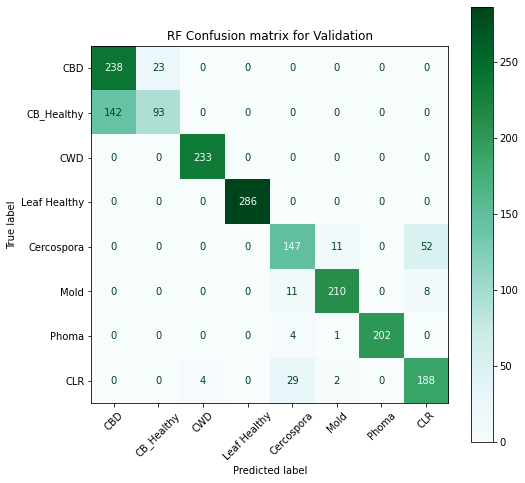

In [45]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_labels, np.ravel(y_test, order='C'))
    print("\tValidation Accuracy of RF: %0.4f" % acc)
    cm = confusion_matrix(actual_targets, predicted_targets, labels=rfc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("RF Confusion matrix for Validation")
    plt.show()

	Training Accuracy of RF: 0.9122


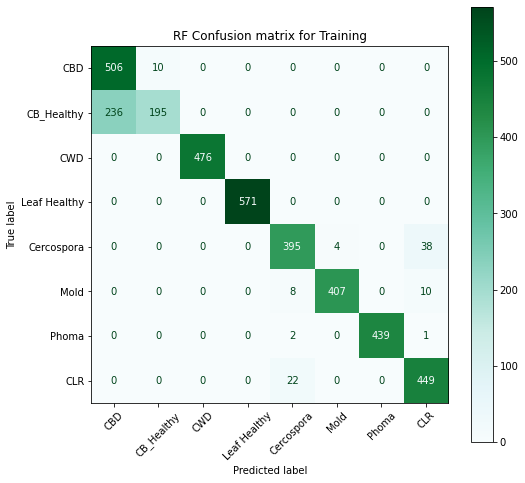

In [39]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_t_labels, np.ravel(y_trin, order='C'))
    print("\tTraining Accuracy of RF: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=rfc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("RF Confusion matrix for Training")
    plt.show()

In [43]:
result = rfc.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_te, order='C'))
print("\tTesting classification report of RF")
print(classification_report(y_te,result,target_names=target_names))

	Testing classification report of RF
              precision    recall  f1-score   support

         CBD       0.63      0.95      0.76       195
  CB_Healthy       0.85      0.34      0.48       166
         CWD       0.98      1.00      0.99       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.75      0.73      0.74       162
        Mold       0.95      0.96      0.95       164
       Phoma       1.00      0.98      0.99       162
         CLR       0.78      0.79      0.79       173

    accuracy                           0.85      1414
   macro avg       0.87      0.84      0.84      1414
weighted avg       0.87      0.85      0.84      1414



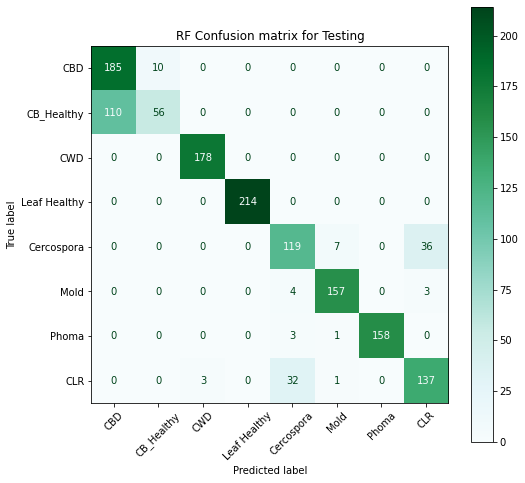

In [41]:
    fig,ax = plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y_te, result, labels=rfc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("RF Confusion matrix for Testing")
    plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix

In [ ]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'CWD',3: 'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

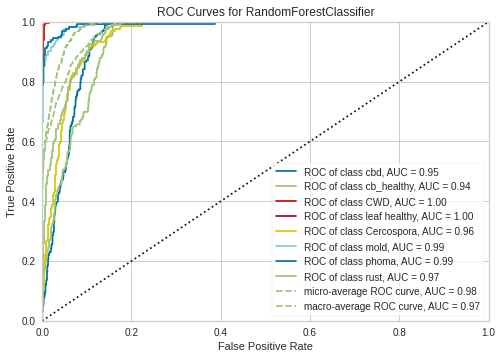

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a060f1e90>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'CWD', 3: 'leaf healthy',
                4: 'Cercospora', 5: 'mold', 6: 'phoma', 7: 'rust'},
       estimator=RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='log2', n_estimators=500,
                                        random_state=42))

In [ ]:
plot_ROC_curve(rfc,Xtrain,y_tr,Xtest,y_te)